In [1]:
import sys
import os
from google.colab import drive

drive.mount('/content/drive')
project_path = '/content/drive/MyDrive/Deep_learning_papers/Neural_probabilistic_laguage_model'

if project_path not in sys.path:
    sys.path.insert(0, project_path)

from utils.data_preparator import *

Mounted at /content/drive


In [ ]:
import nltk
nltk.download('brown')
from nltk.corpus import brown
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import random
import math

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [ ]:
# Wyczyść cache i zresetuj
torch.cuda.empty_cache()
torch.cuda.synchronize()

# Sprawdź czy są błędy
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Current device: {torch.cuda.current_device()}")

CUDA available: True
Current device: 0


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
block_size = 3
Xtr, Xval, Xte, Ytr, Yval, Yte = build_dataset(brown.words(), block_size, device=device)

 There are: 1161192 tokens in dataset
torch.Size([1161192, 3]) torch.Size([1161192])


In [ ]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True, device=None):
        self.weight = (torch.randn((fan_in, fan_out)) / fan_in**0.5).to(device)
        self.bias = torch.zeros(fan_out).to(device) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

class Embeddings:
    def __init__(self, num_embeddings, embedding_dim, device=None):
        self.weight = torch.randn((num_embeddings, embedding_dim)).to(device)

    def __call__(self, IX):
        self.out = self.weight[IX]
        # NEW: Flatten the output immediately inside this layer
        # Transforms [Batch, 3, 150] -> [Batch, 450]
        self.out = self.out.view(self.out.shape[0], -1)
        return self.out

    def parameters(self):
        return [self.weight]

class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
torch.manual_seed(42)

In [ ]:
n_emb = 60
n_hidden = 60
model = Sequential([
    Embeddings(vocab_size, n_emb, device=device),
    Linear(n_emb*3, n_hidden, bias=True, device=device),
    Tanh(),
    Linear(n_hidden, vocab_size, bias=True, device=device),
])

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

2030471


In [ ]:
max_steps = 10000
batch_size = 64
lossi = []

In [ ]:
for i in range(max_steps):

  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)

  for p in parameters:
    p.grad = None
  loss.backward()

  lr = 0.1 if i <150000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/  10000: 9.8069


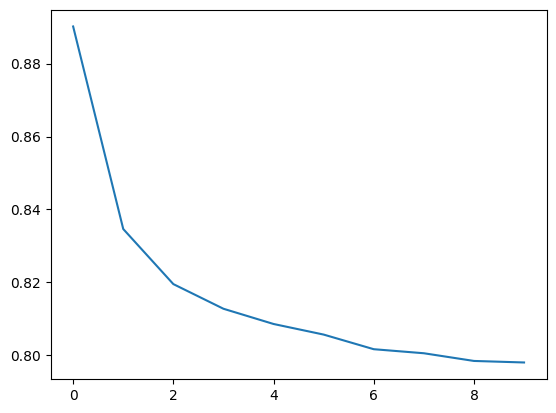

In [ ]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [ ]:
for layer in model.layers:
  layer.training = False

In [ ]:
from tkinter.constants import X
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]

    # Evaluate in batches to avoid OutOfMemoryError
    batch_size_eval = 256  # Can be larger than training batch size as no gradients are computed
    losses = []
    for i in range(0, x.shape[0], batch_size_eval):
        Xb = x[i:i+batch_size_eval]
        Yb = y[i:i+batch_size_eval]
        logits = model(Xb)
        loss = F.cross_entropy(logits, Yb)
        losses.append(loss.item())

    total_loss = torch.tensor(losses).mean()
    print(split, total_loss.item())

split_loss('train')
split_loss('val')

train 6.27374267578125
val 6.199224472045898


In [ ]:
def generate_sentence(model, max_len=20):
    context = [0] * 3 # Start with padding/block
    out = []
    model.layers[2].training = False # Ensure eval mode if you had dropout

    for _ in range(max_len):
        x = torch.tensor([context], device=device)
        logits = model(x)
        probs = F.softmax(logits, dim=1)
        # Sampling
        ix = torch.multinomial(probs, num_samples=1).item()

        if ix == 0: # Koniec zdania / Block
            break

        context = context[1:] + [ix]
        out.append(ix)

    return ' '.join(itos[i] for i in out)

print("Generated:", generate_sentence(model))

Generated: so and the personal man that the filling press . during ? about tools streets . that things to peru
